In [82]:
%matplotlib inline


# Exploring K-Means clustering on the handwritten digits data

This lab is modified from the [Scikit Learn example](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html).


## Goals

- Learn to import and load datasets with numpy
- Use [KMeans](https://scikit-learn.org/stable/modules/clustering.html#k-means) to conduct unsupervised learning
- Explore the impact of initialization and iterations
- Explore a mistmatch of `K` and the number of classes

# Day 1

## Load the dataset

We will start by loading the `digits` dataset. This dataset contains
handwritten digits from 0 to 9. In the context of clustering, one would like
to group images such that the handwritten digits on the image are the same.



In [83]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


We can also display a sample from the dataset, so we know what we are working with.
Note that the images are fairly blurry becasue they are only 8x8 pixels. *Is this enough for our machine learning to reliably work?*

Sample labeled as 3


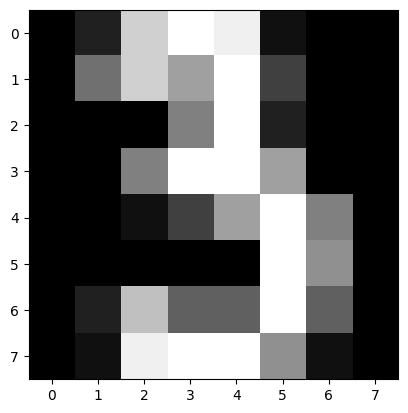

In [84]:
import matplotlib.pyplot as plt
from random import randrange

# select a random sample
sample_id = randrange(n_samples)
sample_image = data[sample_id]

# reshape the vector back to a 2D image
sample_image = np.reshape(sample_image, (8, 8))

# plot the sample
print(f"Sample labeled as {labels[sample_id]}")
plt.imshow(sample_image, cmap='gray')
plt.show()

## Visualize the results on PCA-reduced data

:class:`~sklearn.decomposition.PCA` allows to project the data from the
original 64-dimensional space into a lower dimensional space. Subsequently,
we can use :class:`~sklearn.decomposition.PCA` to project into a
2-dimensional space and plot the data and the clusters in this new space.



In [86]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_kmeans(reduced_data, kmeans, iteration):

  # Step size of the mesh. Decrease to increase the quality of the VQ.
  h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

  # Plot the decision boundary. For that, we will assign a color to each
  x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
  y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

  # Clear previous plot
  clear_output(wait=True)

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.figure(1)
  plt.clf()
  plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
  )

  plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
  # Plot the centroids as a white X
  centroids = kmeans.cluster_centers_
  plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
  )
  plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross\n"
    "Iteration: {}".format(iteration))
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()

## Iterate with K-Means

Before we use the builtin [fit](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit) method, let's step through what the algorithm is doing. We will do this with [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html).

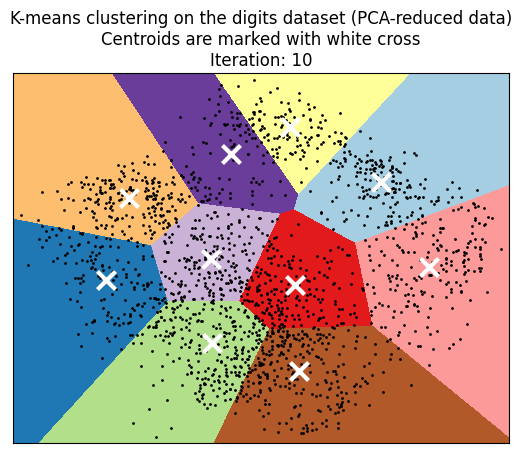

In [87]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from time import sleep


# PCA reduction to 2D
reduced_data = PCA(n_components=2).fit_transform(data)

# initalize
kmeans_step = MiniBatchKMeans(n_clusters=10, init='random', n_init=1, batch_size=10, max_iter=1, random_state=16)
kmeans_step.partial_fit(reduced_data)
# dispaly clusters
plot_kmeans(reduced_data, kmeans_step, 1)
sleep(0.2)

max_iterations = 10
step_size = 1
for i in range(0,max_iterations,step_size):
  # step_size iterations between plots
  for k in range(step_size):
    kmeans_step.partial_fit(reduced_data)

  plot_kmeans(reduced_data, kmeans_step, i)
  sleep(0.05)

plot_kmeans(reduced_data, kmeans_step, max_iterations)

## Fit

We'll now use the built in fit method. Instead of specifying the number of iterations, this method will automatically stop when it **converges**. This is defined as there being no meaningful change of the centroid locations between rounds.

### Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to
compare different initialization methods for KMeans. Our benchmark will:

* create a pipeline which will scale the data using a
  :class:`~sklearn.preprocessing.StandardScaler`;
* train and time the pipeline fitting;
* measure the performance of the clustering obtained via different metrics.



In [88]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### Run the benchmark

We will compare three approaches:

* an initialization using `k-means++`. This method is stochastic and we will
  run the initialization 4 times;
* a random initialization. This method is stochastic as well and we will run
  the initialization 4 times;
* an initialization based on a :class:`~sklearn.decomposition.PCA`
  projection. Indeed, we will use the components of the
  :class:`~sklearn.decomposition.PCA` to initialize KMeans. This method is
  deterministic and a single initialization suffice.



In [94]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# top bar of stats
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

# try with k-means++
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

# try with random
kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

# try with PCA
pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

# bottom bar of stats
print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	1.175s	49511	0.795	0.626	0.701	0.537	0.694	0.101
random   	0.173s	50579	0.812	0.634	0.712	0.560	0.705	0.093
PCA-based	0.416s	50410	0.821	0.644	0.722	0.596	0.715	0.124
__________________________________________________________________________________


# Day 2

Add your own code that accomplishes the following:

1. Imports the sklearn digits dataset
2. Uses sklearn KMeans to fit the digits
3. Iterates the fit over several numbers of classes, both higher and lower than 10
4. Allows for comparison of these results


**Make sure to `Runtime > Restart Runtime` before mvoing from Day 1 to Day 2!**

## Reflection Questions
